In [18]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split

In [20]:
# 2. Model Creation
# ------------------
def create_wavenet_model(input_audio_shape, conditioning_feature_shape):
    """Creates a WaveNet-inspired model for audio generation."""
    # Audio Input
    audio_input = layers.Input(shape=input_audio_shape, name="audio_input")

    # Conditioning Features Input
    conditioning_input = layers.Input(shape=conditioning_feature_shape, name="conditioning_input")

    # Expand conditioning input along the time axis
    conditioning = layers.Dense(input_audio_shape[0], activation="relu")(conditioning_input)
    conditioning = layers.Reshape((input_audio_shape[0], 1))(conditioning)

    # Reshape audio input to match the concatenation dimensions
    audio_input_reshaped = layers.Reshape((input_audio_shape[0], 1))(audio_input)

    # Concatenate audio input and conditioning features
    x = layers.Concatenate()([audio_input_reshaped, conditioning])

    # Add dilated convolution layers with residual connections
    residual = x
    skip_connections = []

    for dilation_rate in [1, 2, 4, 8, 16, 32]:
        x = layers.Conv1D(
            filters=64,
            kernel_size=3,
            dilation_rate=dilation_rate,
            padding="causal",
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(0.01)
        )(x)

        # Create skip connection
        skip_connections.append(x)

        # Ensure the residual connection matches the shape of `x`
        if residual.shape[-1] != x.shape[-1]:
            residual = layers.Conv1D(
                filters=x.shape[-1],
                kernel_size=1,
                padding="same",
                activation="linear"
            )(residual)

        x = layers.Add()([x, residual])  # Add residual connection

    # Sum all skip connections
    x = layers.Add()(skip_connections)

    # Final output layers
    x = layers.Activation("relu")(x)
    x = layers.Conv1D(filters=256, kernel_size=1, activation="relu")(x)
    x = layers.Conv1D(filters=1, kernel_size=1, activation="linear")(x)

    # Create the model
    model = Model(inputs=[audio_input, conditioning_input], outputs=x, name="WaveNet")
    return model

In [21]:
# 3. Model Training
# ------------------
def train_wavenet_model(X_audio_train, X_features_train, y_train, 
                        X_audio_val, X_features_val, y_val, 
                        input_audio_shape, conditioning_feature_shape):
    """Train the WaveNet model with the provided dataset."""
    # Create WaveNet Model
    wavenet_model = create_wavenet_model(input_audio_shape, conditioning_feature_shape)

    # Compile the model
    wavenet_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="mean_squared_error",  # MSE for waveform prediction
        metrics=["mae"]  # Mean Absolute Error
    )

    # Train the model
    history = wavenet_model.fit(
        [X_audio_train, X_features_train], y_train,
        validation_data=([X_audio_val, X_features_val], y_val),
        epochs=30,
        batch_size=8,
        verbose=1
    )

    # Plot Training History
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model Training Progress')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.show()

    return wavenet_model

In [22]:
# 4. Model Evaluation
# --------------------
def evaluate_wavenet_model(wavenet_model, X_audio_test, X_features_test, y_test):
    """Evaluate the WaveNet model on the test dataset."""
    # Evaluate the model
    test_loss, test_mae = wavenet_model.evaluate([X_audio_test, X_features_test], y_test)
    print(f"Test MAE: {test_mae:.2f}")
    print(f"Test Loss: {test_loss:.2f}")


In [23]:
# Load processed dataset
# Load data using relative paths
data_dir = "../../data/processed/wavenet_data/"
X_audio_train = np.load(os.path.join(data_dir, "X_audio_train.npy"))
X_audio_val = np.load(os.path.join(data_dir, "X_audio_val.npy"))
X_audio_test = np.load(os.path.join(data_dir, "X_audio_test.npy"))

X_features_train = np.load(os.path.join(data_dir, "X_features_train.npy"))
X_features_val = np.load(os.path.join(data_dir, "X_features_val.npy"))
X_features_test = np.load(os.path.join(data_dir, "X_features_test.npy"))

y_train = np.load(os.path.join(data_dir, "y_train.npy"))
y_val = np.load(os.path.join(data_dir, "y_val.npy"))
y_test = np.load(os.path.join(data_dir, "y_test.npy"))

# Convert to numpy arrays
X_audio_train = np.array(X_audio_train)
X_audio_val = np.array(X_audio_val)
X_audio_test = np.array(X_audio_test)

X_features_train = np.array(X_features_train)
X_features_val = np.array(X_features_val)
X_features_test = np.array(X_features_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - loss: 139.5463 - mae: 6.9899 - val_loss: 14.5983 - val_mae: 2.7051
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - loss: 15.8716 - mae: 2.8438 - val_loss: 13.8929 - val_mae: 2.6695
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - loss: 13.8271 - mae: 2.6083 - val_loss: 12.3040 - val_mae: 2.4708
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - loss: 13.0770 - mae: 2.5154 - val_loss: 12.5918 - val_mae: 2.5057
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - loss: 12.5040 - mae: 2.4316 - val_loss: 13.6461 - val_mae: 2.6787
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - loss: 12.7275 - mae: 2.5326 - val_loss: 13.1555 - val_mae: 2.6147
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - loss: 12.1066 - mae: 2.3846 - val_loss: 12.8885 - val_mae: 2.5732
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - loss: 11.9890 - mae: 2.3899 - val_loss: 11.6286 - val_mae: 2.4095
Epoch 9/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step -

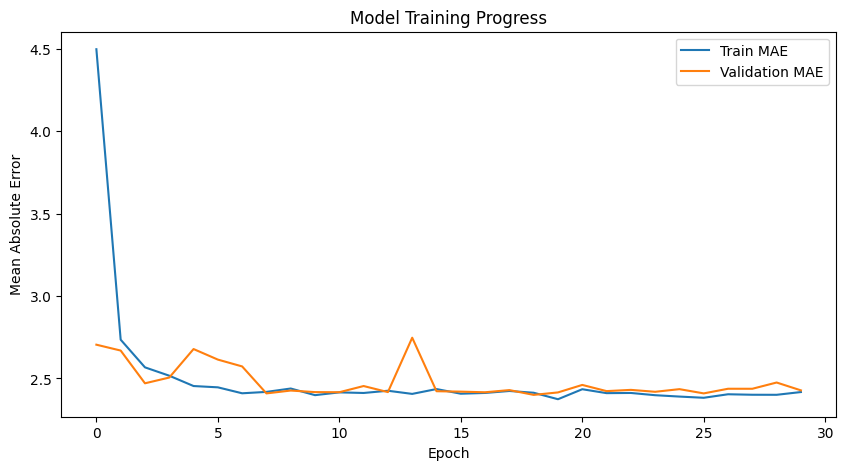

In [25]:
# Define input shapes
input_audio_shape = (8000,)  # 1-second chunks
conditioning_feature_shape = (X_features_train.shape[1],)  # Number of conditioning features

# Train the model
wavenet_model = train_wavenet_model(
    X_audio_train, X_features_train, y_train, 
    X_audio_val, X_features_val, y_val, 
    input_audio_shape, conditioning_feature_shape
)


In [26]:
# Evaluate the trained model
evaluate_wavenet_model(wavenet_model, X_audio_test, X_features_test, y_test)


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 12.0944 - mae: 2.4372
Test MAE: 2.46
Test Loss: 12.17


In [27]:
# Save the entire model to a file
data_dir = "../../data/models/"
model_save_path = os.path.join(data_dir, "wavenet_model2.h5")  # Specify the desired path and file name
wavenet_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ../../data/models/wavenet_model2.h5
